# Python Text Analysis: Topic Modeling

We've considered so far how to create numerical representations of words. We've even performed sentiment classification with those numerical representations. How else can we leverage these numerical representations to elucidate structure from natural language?

In this session, we're going to discuss *topic modeling*. In topic modeling, we aim to discover how the documents in a corpus may be modeled as a function of specific topics. This is not the same thing as direct clustering, though, in which we might directly assign each document to a particular cluster.

Consider genre classification. Some books may neatly fall into one genre, such as mystery, science fiction, etc. However, other books may be considered as incorporating multiple genres. You might have a fantasy novel which has mystery components to it, or a romance novel set in the future. In these cases, we don't want to cluster the fantasy novel into a "fantasy" bucket, and the romance novel in a "romance" bucket. We'd instead like to have some measure of assigning various topics, with different magnitudes to documents. This is the goal of topic modeling.

We will use two approaches to perform topic modeling on the same corpus: non-negative matrix factorization, and latent dirichlet allocation.

## Dataset: 20 Newsgroups

We will be using a new dataset called the **20 Newsgroups** dataset. You can find the original page for this dataset [here](http://qwone.com/~jason/20Newsgroups/).

This dataset is comprised of around 18000 newsgroups posts on 20 topics. The split between the train and test set is based upon a messages posted before and after a specific date. The news groups are as follows, with specific labels indicated:

* *Computers*
    * comp.graphics
    * comp.os.ms-windows.misc
    * comp.sys.ibm.pc.hardware
    * comp.sys.mac.hardware
    * comp.windows.x
* *Recreation*
    * rec.autos
    * rec.motorcycles
    * rec.sport.baseball
    * rec.sport.hockey
* *Science*
    * sci.crypt
    * sci.electronics
    * sci.med
    * sci.space
* *Miscellaneous*
    * misc.forsale
* *Politics*
    * talk.politics.misc
    * talk.politics.guns
    * talk.politics.mideast
* *Religion*
    * talk.religion.misc
    * alt.atheism
    * soc.religion.christian
    
Let's begin by importing the dataset. We'll use `scikit-learn` to do so.

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

%matplotlib inline

In [46]:
# Import fetcher function
from sklearn.datasets import fetch_20newsgroups

In [47]:
# Always check the documentation!
full_data, labels = fetch_20newsgroups(
    subset='train',
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True) # X = features, y = labels

Let's take a look at some of the data samples:

In [48]:
print(full_data[5])
print('\n\n--------\n\n')
print(full_data[50])
print('\n\n--------\n\n')
print(full_data[1000])

 
 
I read somewhere, I think in Morton Smith's _Jesus the Magician_, that
old Lazarus wasn't dead, but going in the tomb was part of an initiation
rite for a magi-cult, of which Jesus was also a part.   It appears that
a 3-day stay was normal.   I wonder .... ?


--------


I've been reading, with much confusion, about whether or not to use
ATManager. Lately, all the packages I've been buying have all
included ATManager as a "bonus"
I do some desktop publishing using PageMaker and Coreldraw.
Coreldraw comes with a nifty laser disk that contains over 200 diff
types. Add that to the TTfonts that come with win31 and you have a
decent amount of fonts. I print my creations out on an HP4
Postcript, at 600 dpi resolution with the "Resolution Enhancement 
Technology" and ..  well ... I get some darn good copies. 
So good that there isn't any diff whether or not ATManager is turned
on or not. Is it worth it to run ATM at all? Especially with these
better printer technologies ... and TT?


----

If we take a look at the labels, we see that they're integers, each specifying one of the 20 possible classes:

In [5]:
print(np.unique(labels)) # 20 categories
print(labels.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
(11314,)


We can access the corresponding names of these labels by using a different keyword argument in the original `fetch_20newsgroups` call:

In [6]:
newsgroups = fetch_20newsgroups(
    subset='train',
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"))

In [7]:
list(newsgroups)

['data', 'filenames', 'target_names', 'target', 'DESCR']

In [8]:
newsgroups.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

To simplify our analysis a little bit, we'll only use a portion of this dataset, which will be set by the `n_subsamples` variable. However, you can feel free to adjust this if you want to use a bigger portion of the dataset.

In [9]:
n_subsamples = 2000
data = full_data[:n_subsamples] # grabs the first 2000 rows

## Non-negative Matrix Factorization

Non-negative matrix factorization (NMF) is a dimensionality reduction technique that can be used to perform topic modeling. It was first [introduced](https://www.nature.com/articles/44565) by Lee and Seung in 1999.

What does *non-negative matrix factorization* mean? Non-negative implies we're not working with any negative numbers, and matrix factorization implies we're taking a matrix, and breaking it down into "factors".

The matrix under consideration is going to be some numerical representation of the text. We've already considered one - the document term matrix! Specifically, we're going to build a TF-IDF matrix from the data - let's call this matrix $V$. Let's remind ourselves what $V$ is: it's a $D\times T$ matrix, where $D$ is the number of documents, and $T$ is the number or terms, or tokens. 

![NMF](../images/nmf.png)

The goal in NMF is to write this matrix as a product of two matrices,

$$
V \approx WH
$$

where $W$ is a $D\times K$ matrix and $H$ is a $K\times T$ matrix. So, in matrix $W$, we can still consider rows as corresponding to documents, and in $H$, we can think of columns as corresponding to terms. But what about $K$, the inner dimension?

We can think of $K$ as enumerating *topics*. If $K$ corresponds to topics, then each row of $H$ corresponds to a different topic. We can interpret $H$ as enumerating what contribution each *term* makes to each *topic*. For example, if the first row of the NMF only has non-zero entries for terms `soccer`, `basketball`, and `baseball`, we might reasonably conclude that the topic corresponds to "sports". The numbers for each entry indicate the contribution of that term to the topic - so if the topic is mainly baseball, it might have a higher value in that entry.

What does this mean for $W$? It's detailing how each *document* (rows) break down into *topics* (columns). So, we can think of NMF as estimating the contribution different topics to a specific document. In newsgroups, we might expect there to be a large contribution from that "sports" topic above into the samples labeled as "rec.sports.baseball".

The breakdown of the original matrix into $W$ and $H$ can only be interpreted if there are no negative entries in any matrix. We already know a TF-IDF DTM is going to be non-negative. If we guarantee that $W$ and $H$ are as well, we can quite literally think of this factorization is creating building blocks for each document!

There's a small issue here: we can get the breakdown of documents into topics, but it's up to us to "interpret" what the topics might be. This can be tricky business, as we might see. Furthermore, we don't even know how many topics we should pick! There are procedures to identify a good number of topics, but at some level it is subjective.

Let's try fitting an NMF to the newsgroups data. First, we need to use `TfidfVectorizer` to transform the data into a document term matrix (remember how to do this?).

In [10]:
# Is this a good scenario to be removing stop words?
n_tokens = 1000

vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=n_tokens,
    stop_words="english")

In [13]:
help(TfidfVectorizer)

Help on class TfidfVectorizer in module sklearn.feature_extraction.text:

class TfidfVectorizer(CountVectorizer)
 |  TfidfVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, analyzer='word', stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.float64'>, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
 |  
 |  Convert a collection of raw documents to a matrix of TF-IDF features.
 |  
 |  Equivalent to :class:`CountVectorizer` followed by
 |  :class:`TfidfTransformer`.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  ----------
 |  input : {'filename', 'file', 'content'}, default='content'
 |      - If `'filename'`, the sequence passed as an argument to fit is
 |        expected to be a list of filenames that need reading to fetc

In [11]:
# Perform vectorizing
tfidf = vectorizer.fit_transform(data)
tokens = vectorizer.get_feature_names_out()

In [12]:
# How many samples, and how many tokens?
tfidf.todense().shape

(2000, 1000)

Let's look at the tokens with highest TF-IDF scores:

In [14]:
tfidf_df = pd.DataFrame(
    tfidf.todense(),
    columns=tokens)
tfidf_df.sum(axis=0).sort_values(ascending=False).head(30)

just       51.111155
like       49.998127
know       48.025455
don        46.832661
think      43.324609
people     42.849943
does       38.999550
good       36.525065
use        36.486090
new        34.365613
thanks     34.115942
time       33.463438
edu        33.164906
want       28.151041
ve         27.952071
way        27.492449
need       27.412769
god        27.212769
make       26.242879
really     25.264408
right      25.030076
problem    25.003239
ll         24.505225
windows    24.364468
say        24.320746
used       23.550788
year       22.902646
did        22.804684
mail       22.258363
using      22.114315
dtype: float64

We can perform NMF using the `NMF` module from `scikit-learn`:

In [15]:
from sklearn.decomposition import NMF

In [17]:
n_components = 10
random_state = 1

nmf = NMF( #NMF = non negative matrix factorization
    n_components=n_components,
    random_state=random_state,
    l1_ratio=0.5,
    init='nndsvda',
    max_iter=500).fit(tfidf)

We can take a look at the $H$ matrix, or the topics, by examining the `components_` member variable:

In [18]:
print(nmf.components_.shape)

(10, 1000)


Let's take a peek at the distribution of values in the first topic:

<BarContainer object of 1000 artists>

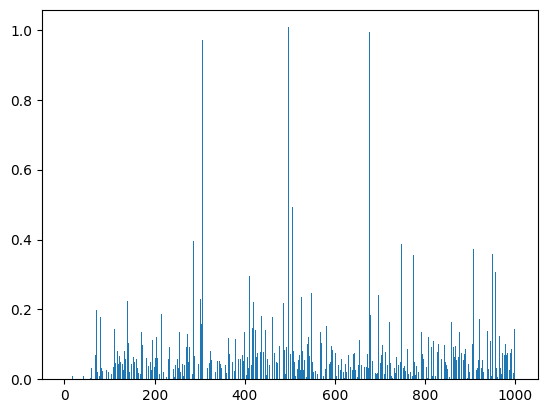

In [19]:
fig, ax = plt.subplots(1, 1)

ax.bar(x=np.arange(n_tokens), height=nmf.components_[0])

This is nice, but it'd be nice to look at the top tokens - the large spikes we see there - and ignore all the smaller contributions to a topic. We'll use a plotter function which will nicely show the largest contributions to each topic, as well as what the corresponding tokens are:

In [20]:
def plot_top_words(model, feature_names, n_top_words=10, n_row=2, n_col=5, normalize=False):
    """Plots the top words from a topic model.
    
    Parameters
    ----------
    model : topic model object (e.g., LatentDirichletAllocation, NMF)
        The trained topic model. It should have a components_ attribute.
    feature_names : array-like of strings
        The names of each token, as a list or array.
    n_top_words : int
        The number of words to plot for each topic.
    n_row : int
        The number of rows in the plot.
    n_col : int
        The number of columns in the plot.
    normalize : boolean
        If True, normalizes the components so that they sum to 1 along samples.
    """
    # Create figure
    fig, axes = plt.subplots(n_row, n_col, figsize=(3 * n_col, 5 * n_row), sharex=True)
    axes = axes.flatten()
    components = model.components_
    # Normalize components, if necessary
    if normalize:
        components = components / components.sum(axis=1)[:, np.newaxis]
    # Iterate over each topic
    for topic_idx, topic in enumerate(components):
        # Obtain the top words for each topic
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        # Get the token names
        top_features = [feature_names[i] for i in top_features_ind]
        # Get their values
        weights = topic[top_features_ind]

        # Plot the token weights as a bar plot
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        
        # Customize plot
        for i in "top right left".split():
            ax.spines[i].set_visible(False)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)

    return fig, axes

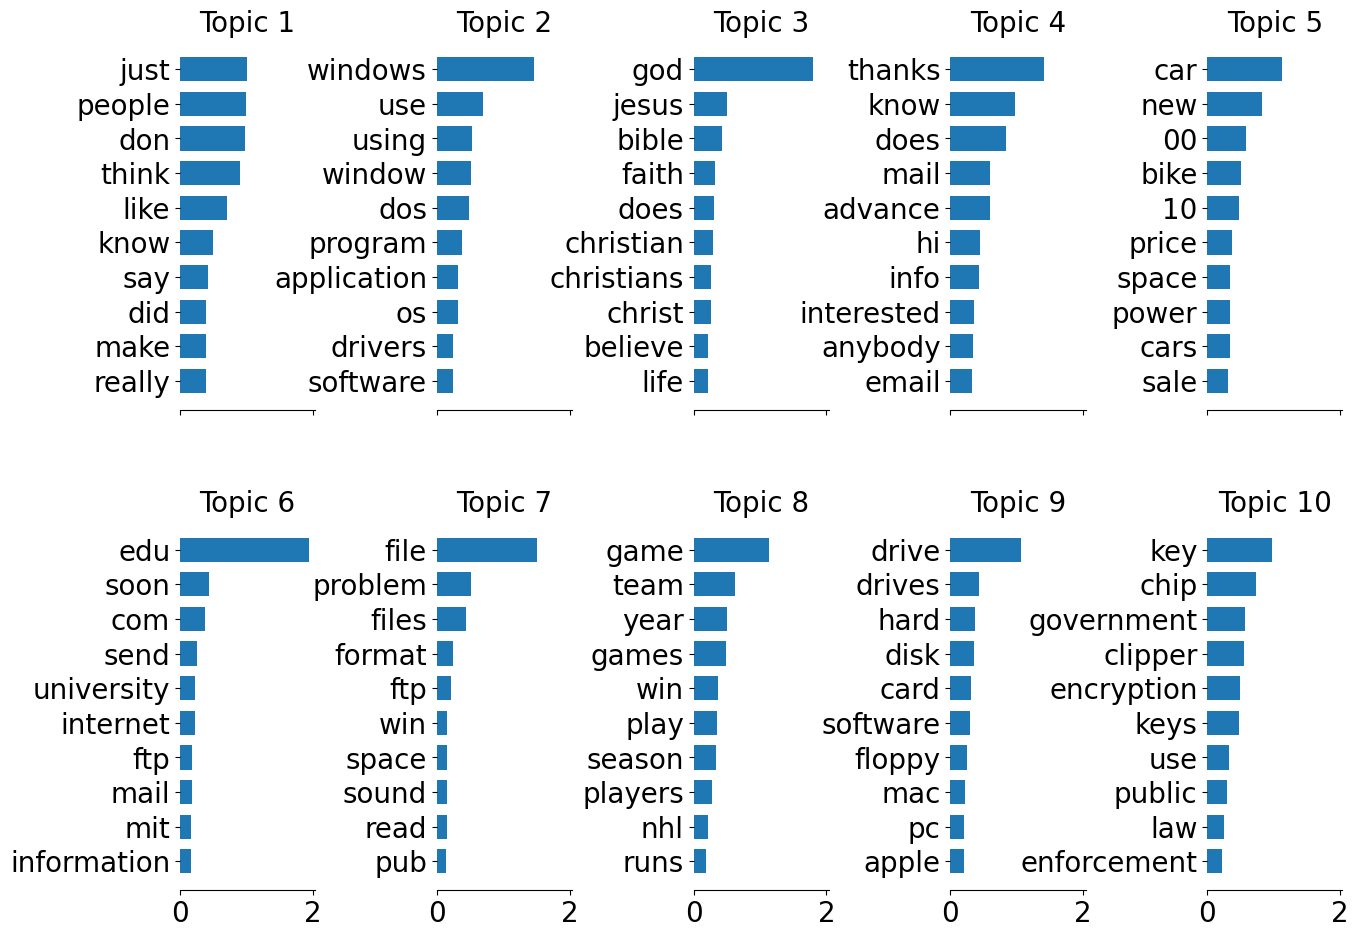

In [21]:
fig, axes = plot_top_words(nmf, tokens)
plt.show()

What can we tell from this? For one, Topic 2 looks like it might be related to computers, Topic 3 looks very much like a topic related to religion, and Topic 8 looks like it's about sports. Note that, if you used a different random seed, these topics might look different for you.

Some of the topics look a little bit harder to interpret, and that comes with the territory in topic modeling.

We were able to get the $H$ matrix, but what about the $W$ matrix? To get this, we need to *transform* the DTM into the *basis* created by the NMF factorization. We can do this with the `transform` function:

In [22]:
W = nmf.transform(tfidf)
print(W.shape)

(2000, 10)


Let's take a look at a random entry:

In [23]:
entry = 999
print(data[999])


One should be aware that foreign doctors admitted for training
are ineligible to apply for resident alien status.  In order
to get the green card they have to return to their country and
apply at the embassy there.  Of course, many somehow get around
this problem.  Often it is by agreeing to practice in a town
with a need and then the congressman from that district tacks
a rider onto a bill saying "Dr. X will be allowed to have permanent
residency in the US."  A lot of bills in congress have such riders
attached to them.  Marrying a US citizen is the most common, although
now they are even cracking down on that and trying to tell US
citizens they must follow their spouse back to the Phillipines, or
whereever.



-- 
----------------------------------------------------------------------------
Gordon Banks  N3JXP      | "Skepticism is the chastity of the intellect, and
geb@cadre.dsl.pitt.edu   |  it is shameful to surrender it too soon." 


The accompanying label for this entry can be obtained from the `newsgroups` variable we created earlier:

In [24]:
newsgroups.target_names[labels[999]]

'sci.med'

Let's examine the breakdown of this entry by topic:

Text(0.5, 0, 'Topic')

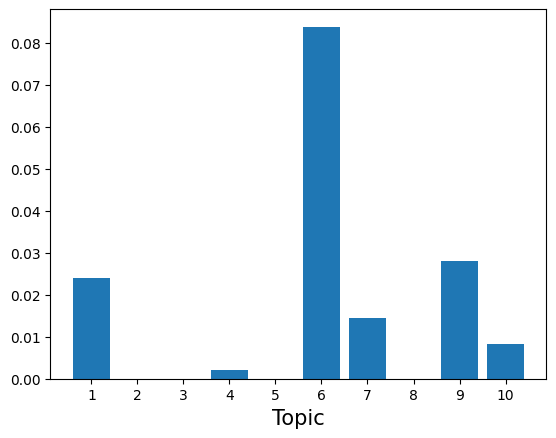

In [25]:
fig, ax = plt.subplots(1, 1)
ax.bar(x=np.arange(n_components), height=W[999])
ax.set_xticks(np.arange(n_components))
ax.set_xticklabels(np.arange(n_components) + 1)
ax.set_xlabel('Topic', fontsize=15)

What does this tell you?

Notice that many of the topics have been zeroed out entirely - this is a product of enforcing *sparsity* in the model, and it stems from the `alpha` parameter in the NMF.

---

### Challenge 1: Exploring Hyperparameters in NMF

The choice of 10 components was somewhat arbitrary. It was something we had to do before we could proceed with fitting the model to the data. This is what's known as a *hyperparameter*. There are other hyperparameters in the `NMF`. For example, the `alpha` values specifies to what degree we should force values to be set equal to zero.

Try fitting the NMF with other variations of hyperparameters, and plot the resulting topics using the `plot_top_words` function. What do you notice?

---

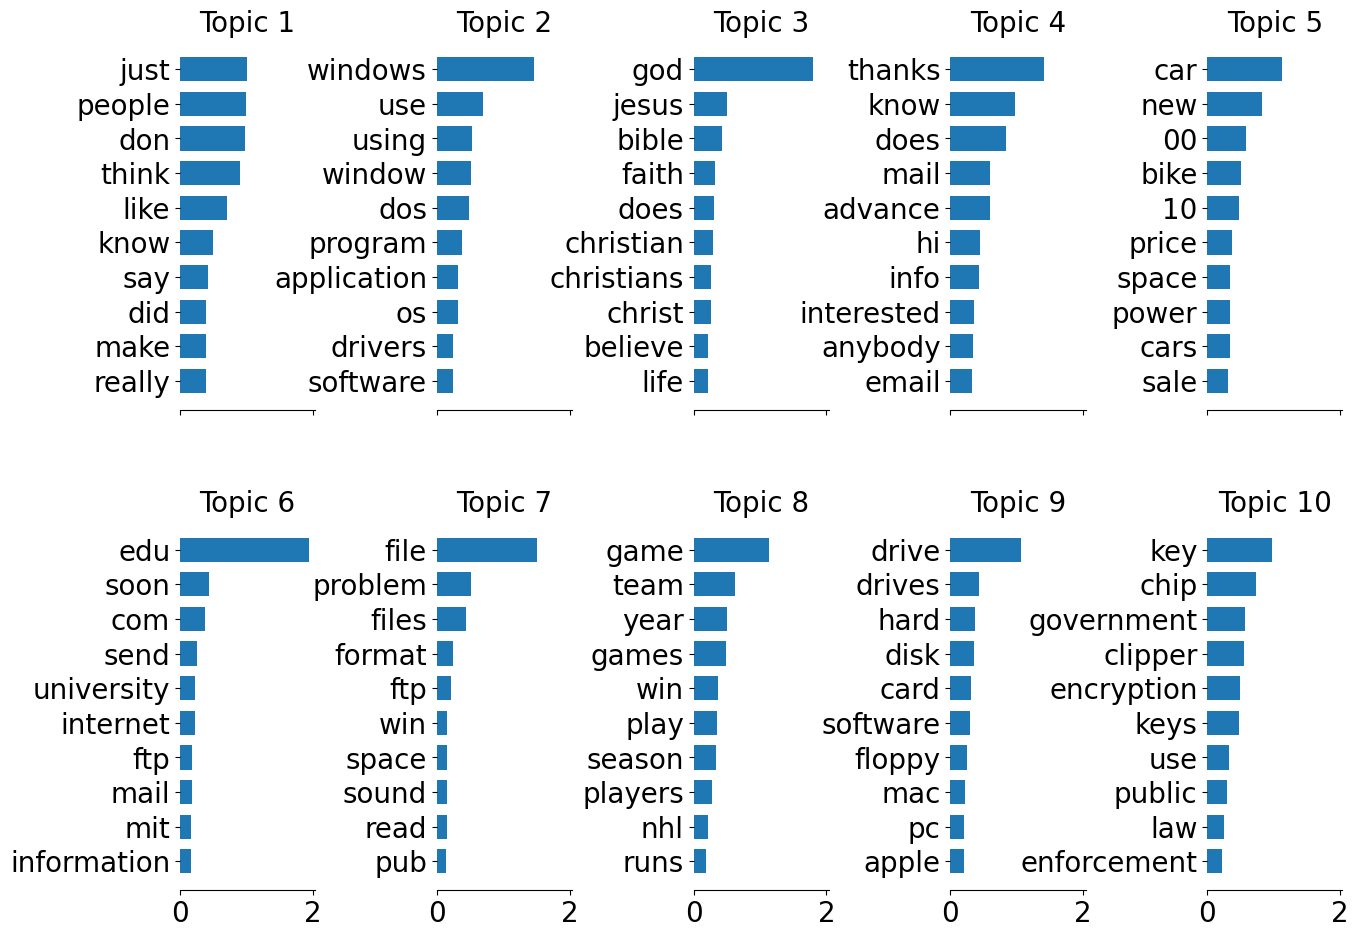

In [27]:
n_components = 10
random_state = 1

nmf = NMF( #NMF = non negative matrix factorization
    n_components=n_components,
    random_state=random_state,
    l1_ratio=0.5,
    init='nndsvda',
    max_iter=500).fit(tfidf)


fig, axes = plot_top_words(nmf, tokens)
plt.show()

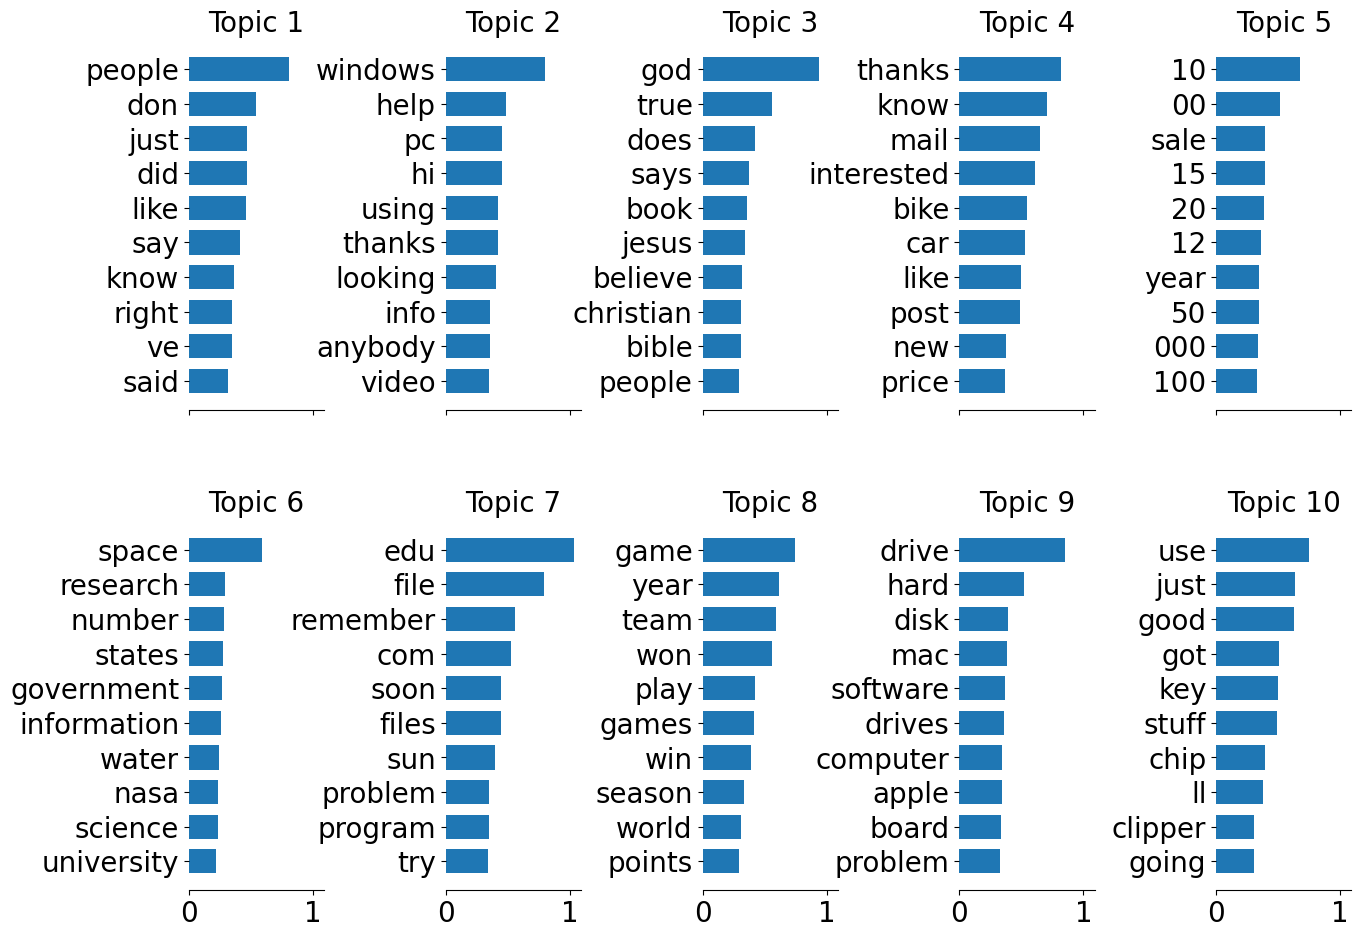

In [29]:
n_components = 10
random_state = 1

nmf = NMF( #NMF = non negative matrix factorization
    n_components=n_components,
    random_state=random_state,
    l1_ratio=0.5,
    init='nndsvda',
    solver = 'mu',
    beta_loss = 'kullback-leibler',
    max_iter=500).fit(tfidf)


fig, axes = plot_top_words(nmf, tokens)
plt.show()

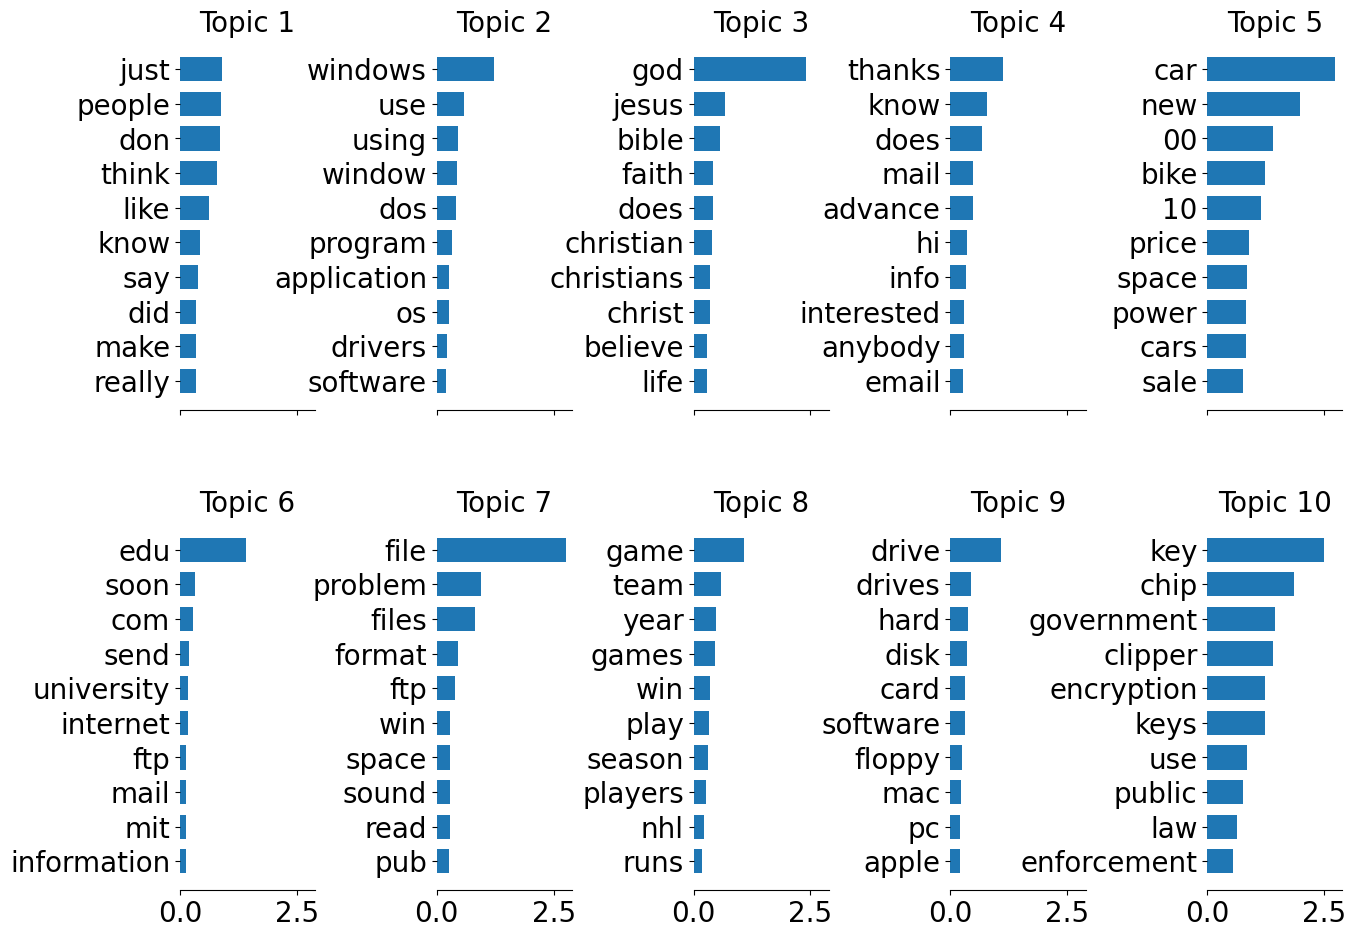

In [30]:
n_components = 10
random_state = 1

nmf = NMF( #NMF = non negative matrix factorization
    n_components=n_components,
    random_state=random_state,
    l1_ratio=0.5,
    init='nndsvda',
    shuffle = True,
    max_iter=500).fit(tfidf)


fig, axes = plot_top_words(nmf, tokens)
plt.show()

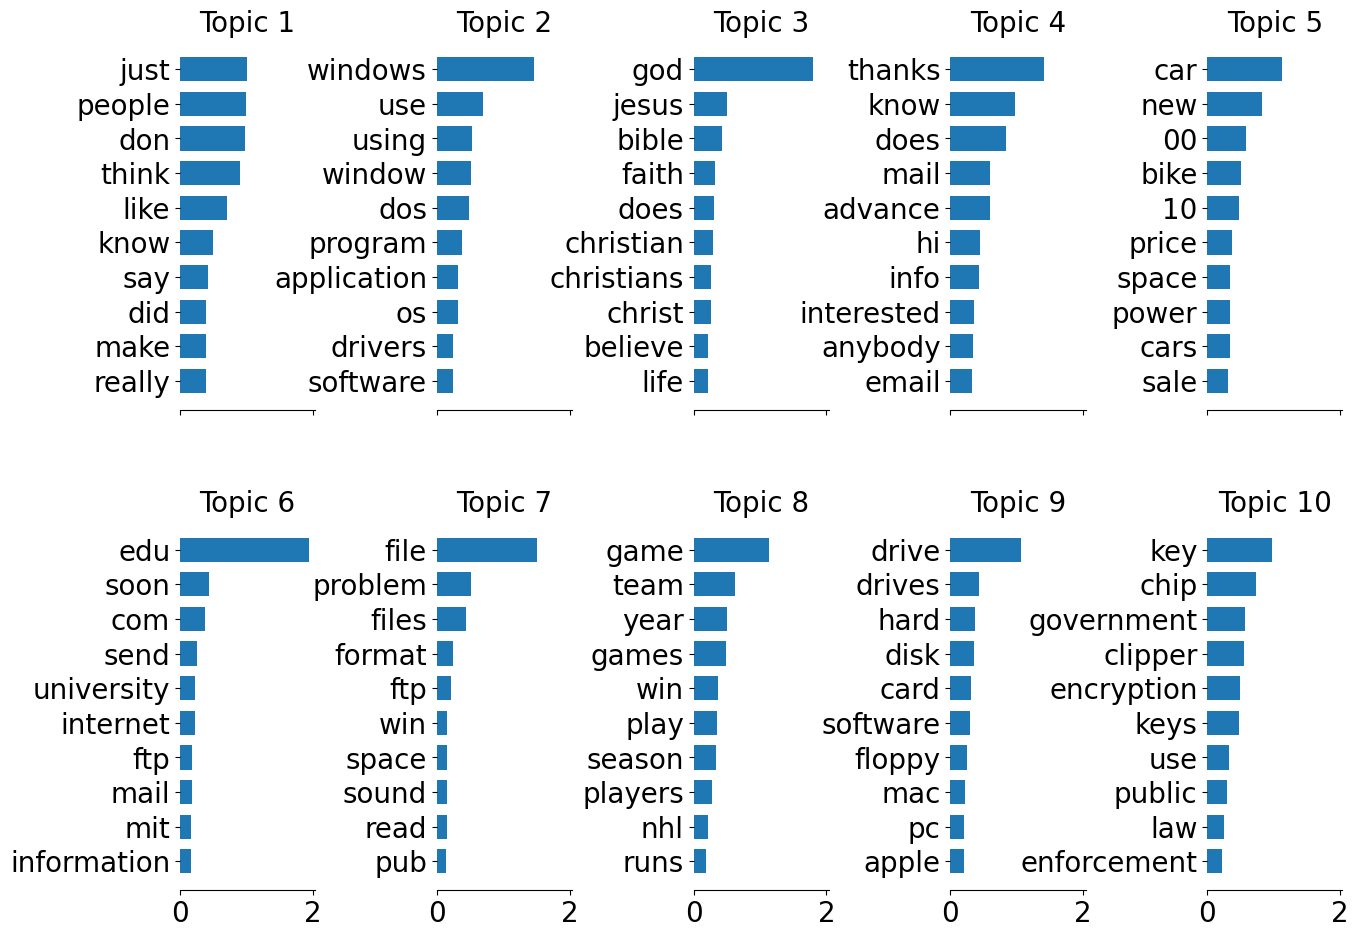

In [31]:
n_components = 10
random_state = 1

nmf = NMF( #NMF = non negative matrix factorization
    n_components=n_components,
    random_state=random_state,
    l1_ratio=0.5,
    init='nndsvda',
    max_iter=500).fit(tfidf)


fig, axes = plot_top_words(nmf, tokens)
plt.show()

## Latent Dirichlet Allocation

Latent Dirichlet Allocation (LDA) is a Bayesian model that captures how specific topics can generate documents. It was [introduced](https://jmlr.csail.mit.edu/papers/v3/blei03a.htmlhttps://jmlr.csail.mit.edu/papers/v3/blei03a.html) in machine learning by Blei et al. It is one of the oldest models applied to perform topic modeling.

One significant difference between LDA and NMF is that LDA is a *generative* model. This means that it can be used to *generate* new documents, by sampling from it. Assume we have a number of topics $T$. Then, we generate a new document as follows:

1. Choose a number of words $N$ according to a Poisson distribution. If you're not familiar with a Poisson distribution, don't worry - the only thing you need to know is that the outputs from a Poisson distribution can only be nonnegative integers (e.g., 0, 1, 2, 3 ...).
2. Choose a vector of values $\boldsymbol{\theta}=(\theta_1, \theta_2, \ldots, \theta_T)$ from a Dirichlet distribution. The details of a Dirichlet distribution aren't too important other than that it guarantees all of the $\theta_i$ add up to 1, and are positive. So, we can think of the $\theta_i$ as proportions, or probabilities.
3. For each of the $N$ words $w_n$:
- Choose a topic $t_n$ according to a Multinomial distribution following $\boldsymbol{\theta}$. In other words, choose a topic according to the probabilities set by $\boldsymbol{\theta}$ (remember, we're thinking of these values as proportions, or probabilities).
- Choose a word $w_n$ from a probability distribution $p(w_n|t_n)$ conditioned on $t_n$. This probability distribution is another Multinomial distribution.

LDA does not model the order of the words, so in the end, it produces a collection of words - just like the bag of words.

![lda](../images/lda.png)

There's a lot of variables there, so let's consider a concrete example. Let's suppose we have two topics: soccer and basketball. These are $t_1$ and $t_2$. 

Some topics are more likely to contains words than others. For example, soccer is more likely to contain `liverpool` and `freekick`, but probably not `nba`. Basketball meanwhile will very likely contain `rebound` and `nba`. Furthermore, even though it's unlikely, a soccer topic might still refer to the `nba`. This unlikeliness is captured through the probabilities assigned in the distribution $p(w_n|t_n)$.

Next, each document might consist of multiple "proportions" of topics. We've already seen this in NMF, only this time, LDA captures this via a probability distribution rather than a matrix operation. So, Document 1 might mainly be about Soccer, and not really reference basketball - this would be reflected in the probabilities $\boldsymbol{\theta}=(0.9, 0.1)$. Meanwhile, another document might equally reference soccer and basketball, so we'd need a different set of parameters $\boldsymbol{\theta}=(0.5, 0.5)$.

Once again, we're going to use `scikit-learn` to perform LDA. This time, however, we'll use a `CountVectorizer`, since LDA explicitly models *counts*.

In [32]:
# Use a CountVectorizer
n_tokens = 1000
count_vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=n_tokens,
    stop_words="english")

In [33]:
# Fit and transform CountVectorizer
counts = count_vectorizer.fit_transform(data)
print(counts.shape)

(2000, 1000)


In [34]:
tokens = count_vectorizer.get_feature_names_out()

This DTM is going to look very similar to the previous DTM, so let's proceed to the LDA fitting!

In [35]:
from sklearn.decomposition import LatentDirichletAllocation

In [40]:
n_components = 10
random_state = 0

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online", # Use when dataset is large
    learning_offset=50.0, 
    random_state=random_state)

In [41]:
# Fit the LDA model!
lda.fit(counts)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

How can we analyze the trained model? The `lda` object also comes with a `components_` variable, which corresponds to the topic word distribution. Let's plot these values using the function we created above:

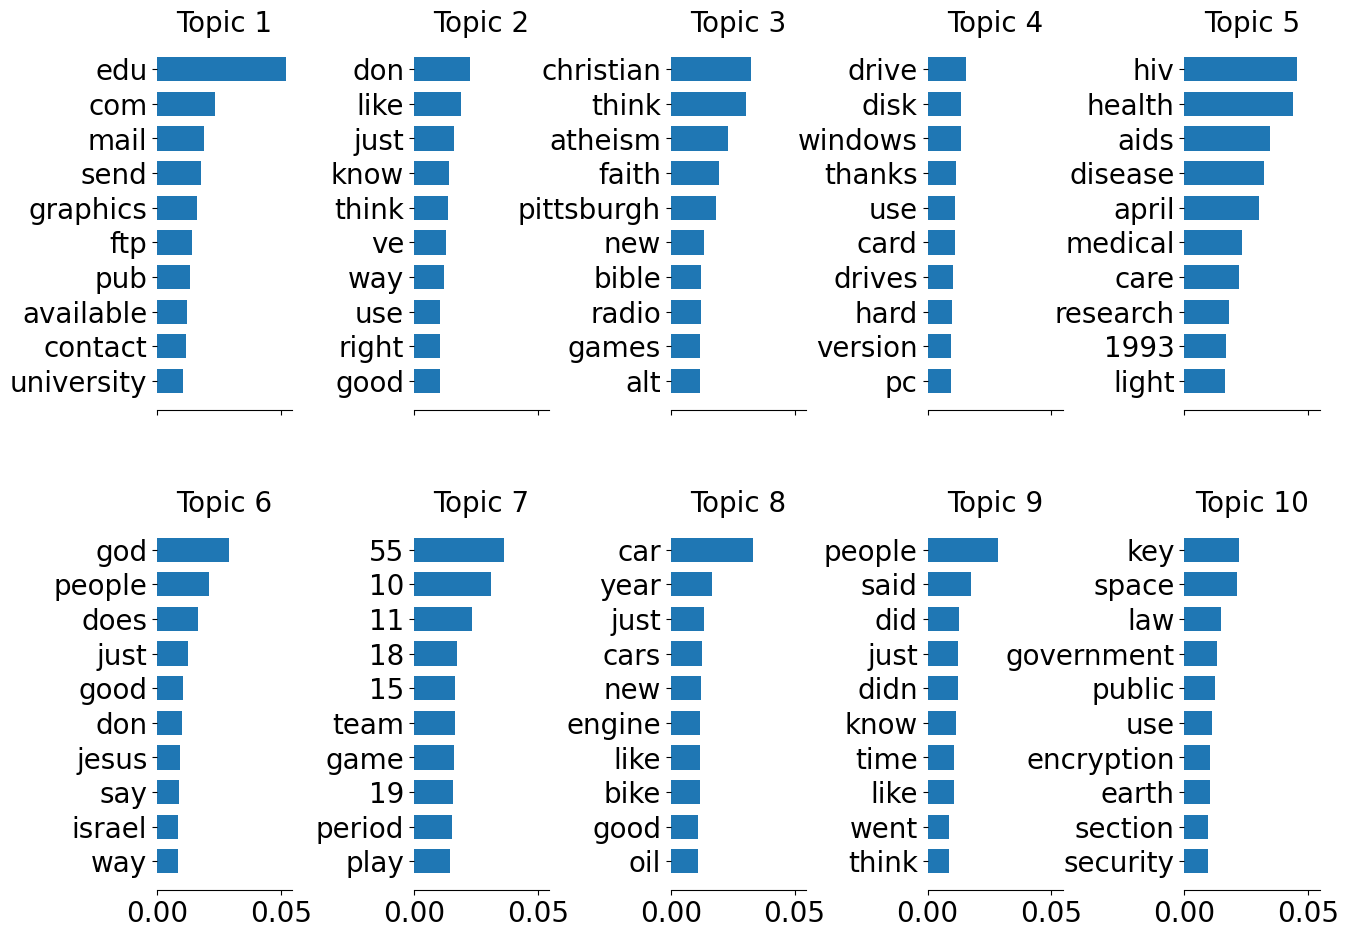

In [42]:
# This time, we're normalizing - what does this do?
fig, axes = plot_top_words(lda, tokens, normalize=True)
plt.show()

---

### Challenge 2: Exploring Hyperparameters in LDA

As in the case of NMF, try performing LDA with other variations of hyperparameters, and plot the resulting topics using the `plot_top_words` function. Use the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) as a guide to choose different hyperparameters.

---

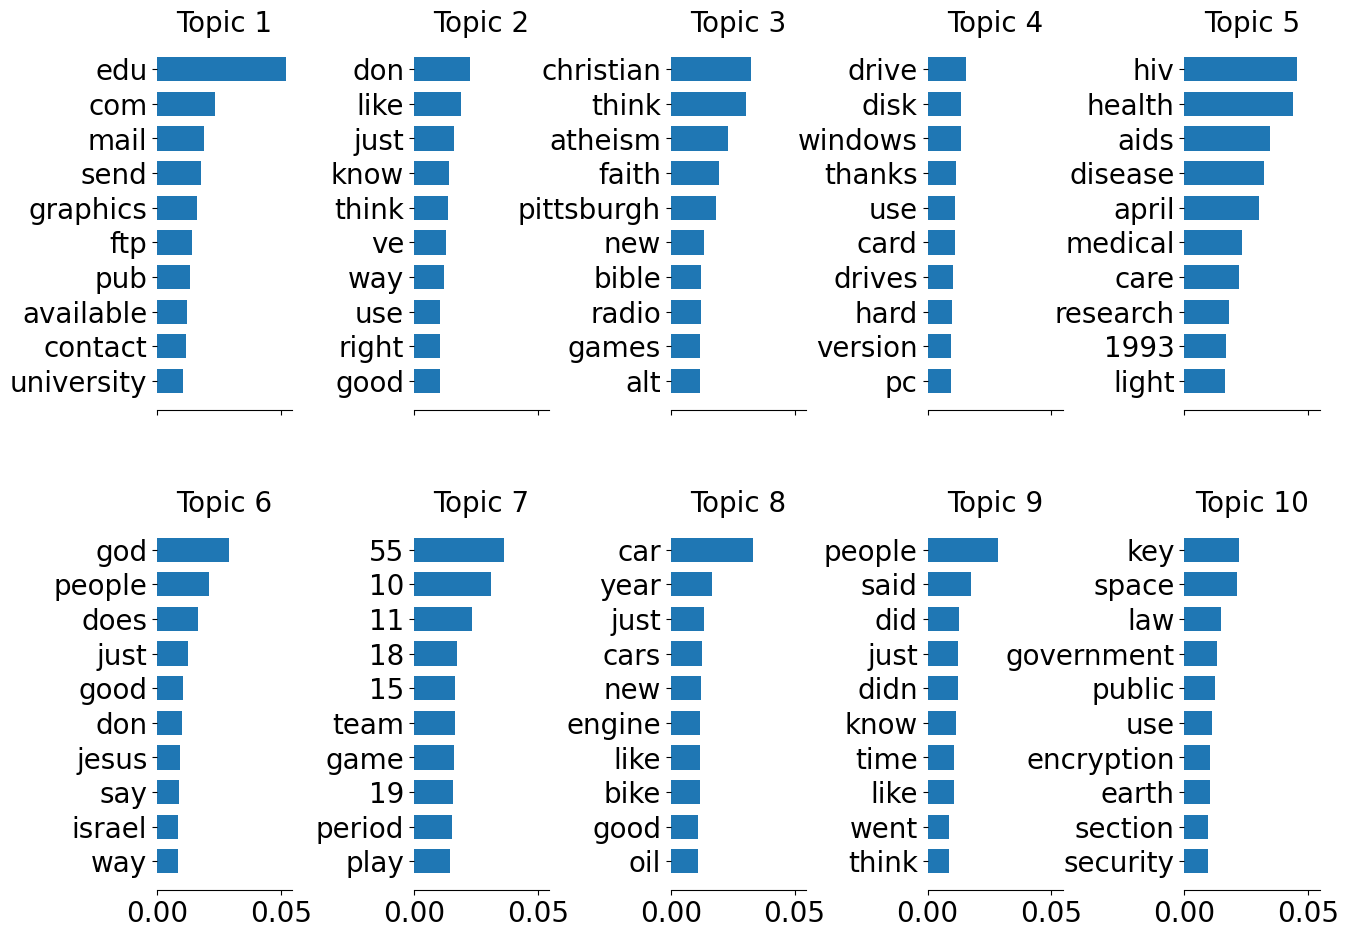

In [54]:
n_components = 10
random_state = 0

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online", # Use when dataset is large
    learning_offset=50.0, 
    random_state=random_state)
# Fit the LDA model!
lda.fit(counts)
# This time, we're normalizing - what does this do?
fig, axes = plot_top_words(lda, tokens, normalize=True)
plt.show()

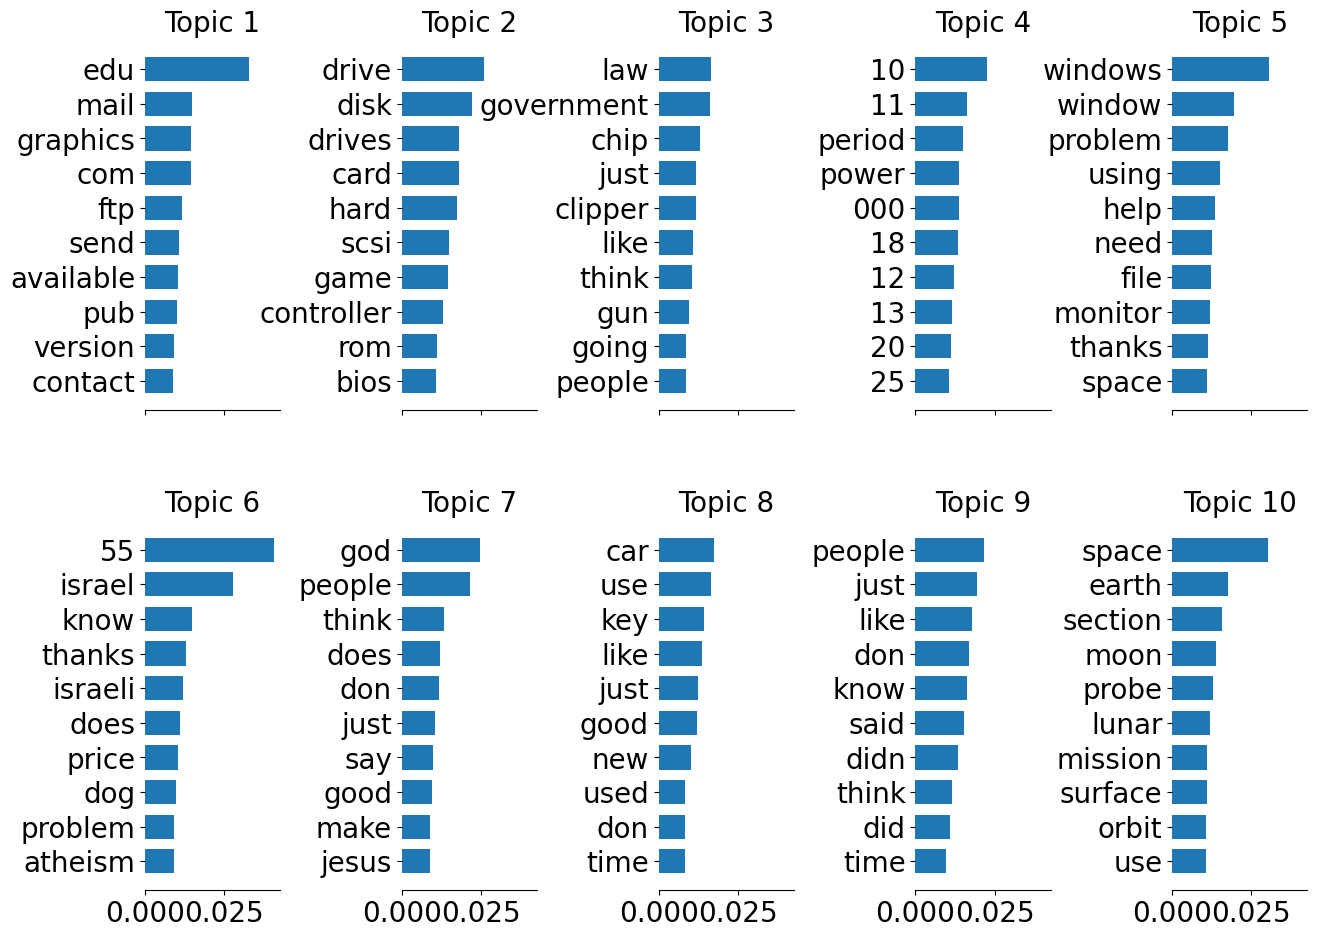

In [56]:
n_components = 10
random_state = 0

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="batch", # Use when dataset is large
    learning_offset=50.0, 
    random_state=random_state)
# Fit the LDA model!
lda.fit(counts)
# This time, we're normalizing - what does this do?
fig, axes = plot_top_words(lda, tokens,   normalize=True)
plt.show()

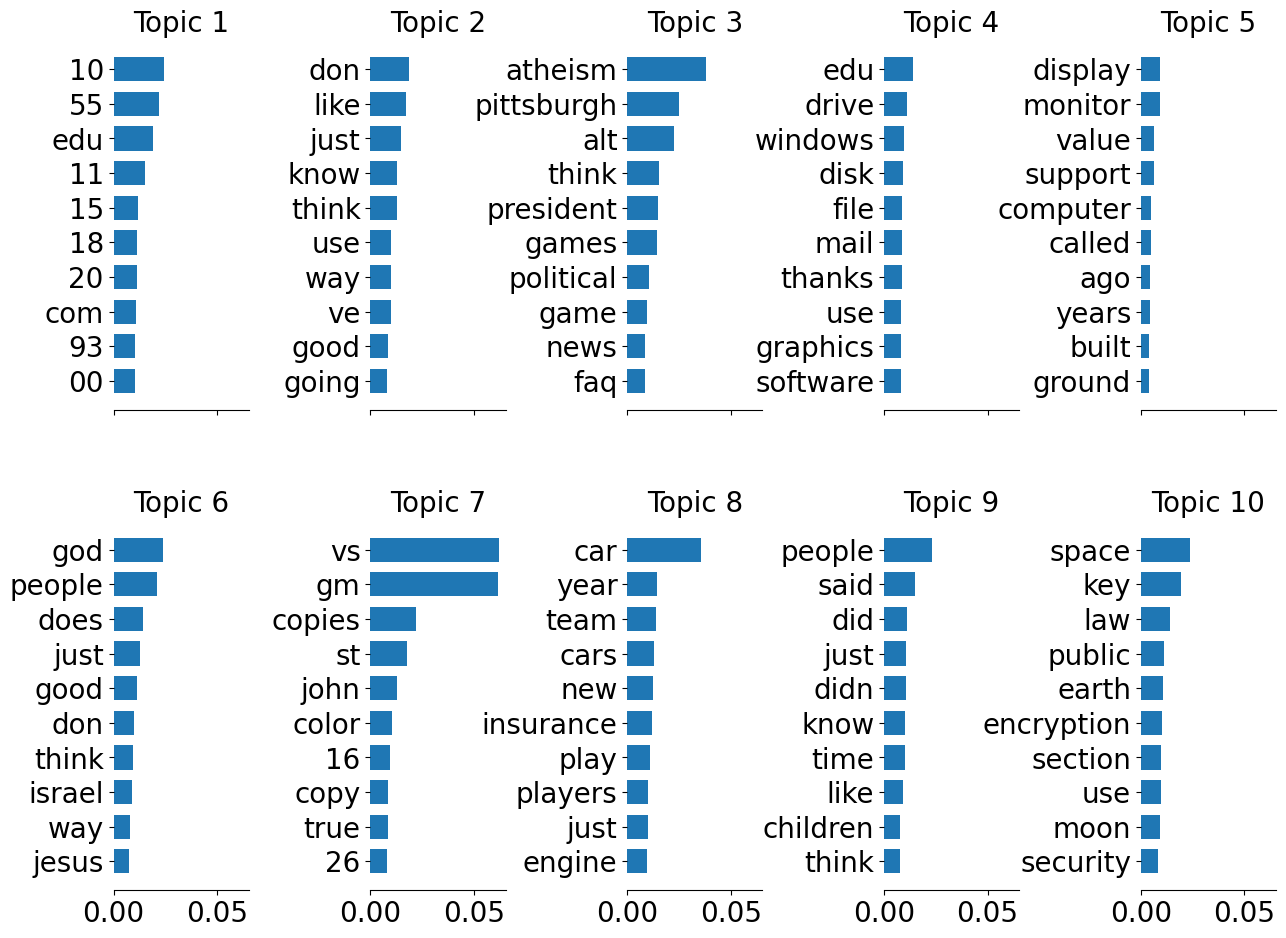

In [57]:
n_components = 10
random_state = 0

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online", # Use when dataset is large
    learning_offset=50.0, 
    learning_decay = 0.9,
    random_state=random_state)
# Fit the LDA model!
lda.fit(counts)
# This time, we're normalizing - what does this do?
fig, axes = plot_top_words(lda, tokens, normalize=True)
plt.show()

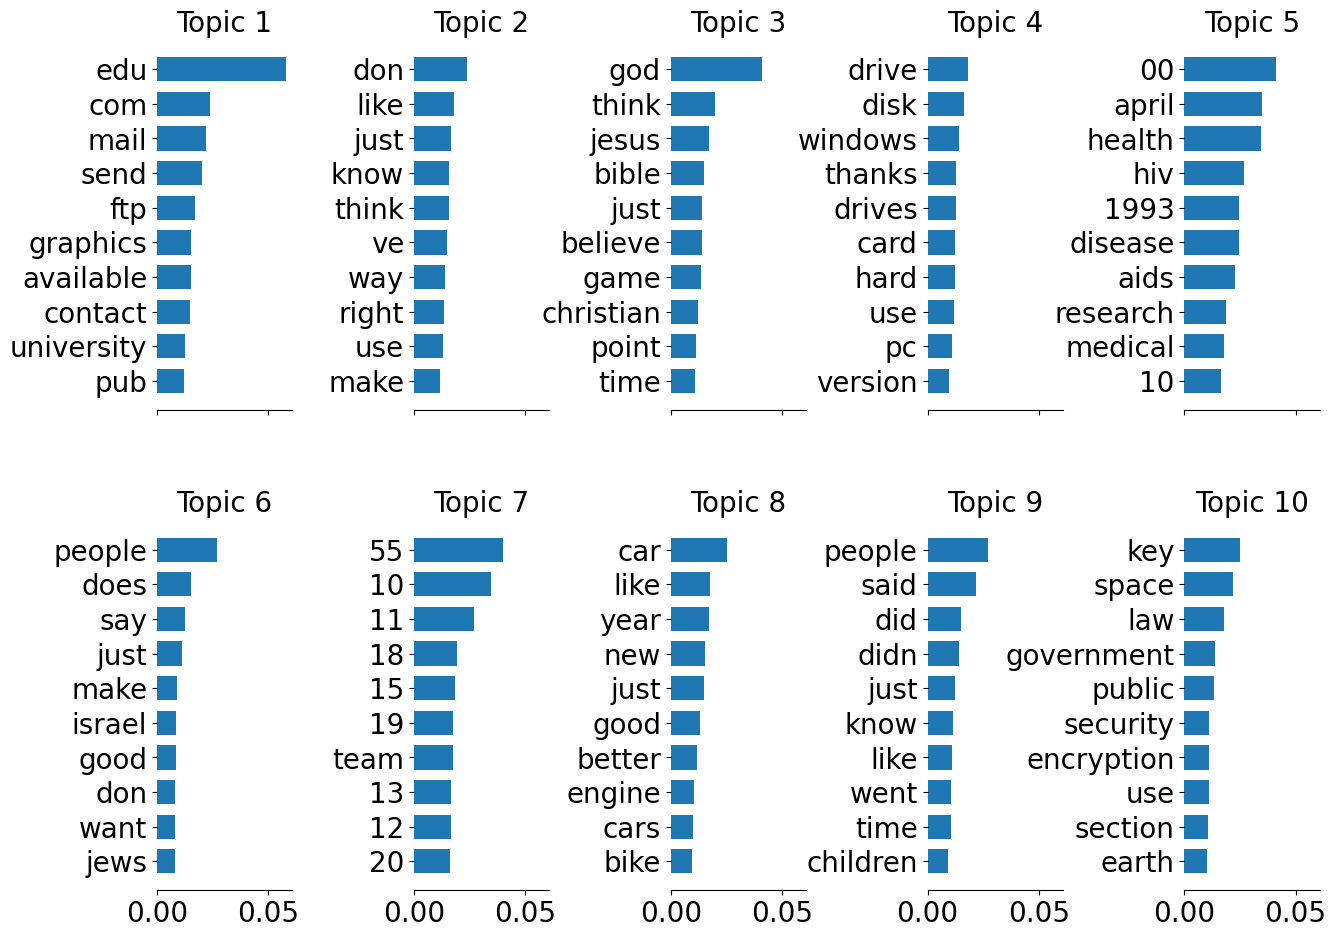

In [58]:
n_components = 10
random_state = 0

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online", # Use when dataset is large
    learning_offset=50.0, 
    learning_decay = 0.55,
    random_state=random_state)
# Fit the LDA model!
lda.fit(counts)
# This time, we're normalizing - what does this do?
fig, axes = plot_top_words(lda, tokens, normalize=True)
plt.show()

## Topic Modeling as Dimensionality Reduction

In both NMF and LDA, we broke down the documents into topics. This was, in effect, a *change in representation*. We went from a DTM representation, to a representation of *topics*. 

Because there are fewer topics than there are tokens, we can think of this as a *dimensionality reduction*. This is desirable for several reasons, the main one being that it's easier to interpret, say, 10 dimensions than it is to interpret 1000.

This is computationally true, as well: once we get to higher dimensions, it's harder to compare different vectors with each other, because they generally end up all close to orthogonal. This is known as the *curse of dimensionality*.

Let's first transform the counts into the topic representation:

In [59]:
topic_representation = lda.transform(counts)
topic_representation.shape

(2000, 10)

We're going to use the cosine similarity to calculate the similarity between pairs of documents (remember this from Word Embeddings?). `scikit-learn` has a `cosine_similarity` function we can use:

In [60]:
from sklearn.metrics.pairwise import cosine_similarity

Let's first calculate the similarity of the first few documents in the term representation:

In [61]:
cosine_similarity(counts[:4])

array([[1.        , 0.        , 0.06681531, 0.05216405],
       [0.        , 1.        , 0.02372895, 0.055577  ],
       [0.06681531, 0.02372895, 1.        , 0.0243975 ],
       [0.05216405, 0.055577  , 0.0243975 , 1.        ]])

Not similar at all! Let's try in the topic representation:

In [62]:
cosine_similarity(topic_representation[:4])

array([[1.        , 0.0093795 , 0.99790381, 0.90127919],
       [0.0093795 , 1.        , 0.00894321, 0.00773232],
       [0.99790381, 0.00894321, 1.        , 0.916992  ],
       [0.90127919, 0.00773232, 0.916992  , 1.        ]])

There's a much bigger spread in the similarities, now. What about the rest of the documents?

---

### Challenge 3: Finding Similar Documents

Calculate the cosine similarity between all pairs of documents, and find the two documents whose cosine similarity is the highest. What are these documents? Do they seem similar?

---

In [63]:
cosine_similarity(counts)

array([[1.        , 0.        , 0.06681531, ..., 0.01583119, 0.02540549,
        0.07715167],
       [0.        , 1.        , 0.02372895, ..., 0.06746792, 0.03609027,
        0.        ],
       [0.06681531, 0.02372895, 1.        , ..., 0.01480872, 0.04752932,
        0.        ],
       ...,
       [0.01583119, 0.06746792, 0.01480872, ..., 1.        , 0.01126158,
        0.        ],
       [0.02540549, 0.03609027, 0.04752932, ..., 0.01126158, 1.        ,
        0.05488213],
       [0.07715167, 0.        , 0.        , ..., 0.        , 0.05488213,
        1.        ]])

In [64]:
matrix_counts = cosine_similarity(counts)

In [66]:
# Set the main diagonal to a very small value to exclude it from the search
np.fill_diagonal(matrix_counts, -np.inf)

# Find the index of the maximum value in the modified matrix
max_index_counts = np.unravel_index(np.argmax(matrix_counts), matrix_counts.shape)

print("Index of the highest entry (excluding main diagonal):", max_index_counts)

Index of the highest entry (excluding main diagonal): (559, 1152)


In [67]:
matrix_counts[(559, 1152)]

1.0

In [68]:
matrix_topic = cosine_similarity(topic_representation)
# Set the main diagonal to a very small value to exclude it from the search
np.fill_diagonal(matrix_topic, -np.inf)

# Find the index of the maximum value in the modified matrix
max_index_topic = np.unravel_index(np.argmax(matrix_topic), matrix_topic.shape)

print("Index of the highest entry (excluding main diagonal):", max_index_topic)

Index of the highest entry (excluding main diagonal): (559, 1152)


In [69]:
matrix_topic[(559, 1152)]

1.0

In [73]:
data[559]

'He who overcomes will inherit all this, and I will be his God and he will\nbe my son. '

In [74]:
data[1152]

'\n\n\tAgreed.\n\n--\n\n\n       "Satan and the Angels do not have freewill.  \n        They do what god tells them to do. "'